In [1]:
## import libraries
import os
import argparse
import random
import numpy as np

import matplotlib.pyplot as plt

# pytorch
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

# self-class
from model import ITrackerModel
from dataset import *
from util import *

# random seed
np.random.seed(7)
random.seed(7)
random_state=7

In [2]:
## random seed
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 0
seed_everything(SEED)

In [3]:
## define parser
parser = argparse.ArgumentParser(description="Train the Net",
                                 formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument("--lr", default=1e-3, type=float, dest="lr")
parser.add_argument("--momentum", default=0.9, type=float, dest="momentum")
parser.add_argument("--weight_decay", default=1e-4, type=float, dest="weight_decay")
parser.add_argument("--current_best", default=1e20, type=float, dest="current_best")
parser.add_argument("--batch_size", default=torch.cuda.device_count()*100, type=int, dest="batch_size")
parser.add_argument("--num_epoch", default=30, type=int, dest="num_epoch")

parser.add_argument("--imSize", default=(224,224), type=int, dest="imSize")
parser.add_argument("--gridSize", default=(25,25), type=int, dest="gridSize")

parser.add_argument("--data_dir", default="/home/kerrykim/PycharmProjects/eyetracking_data/dataset_ssmall/", type=str, dest="data_dir")
parser.add_argument("--ckpt_dir", default="./checkpoint", type=str, dest="ckpt_dir")
parser.add_argument("--log_dir", default="./log", type=str, dest="log_dir")
parser.add_argument("--result_dir", default="./result", type=str, dest="result_dir")

parser.add_argument("--train/test_mode", default="train", type=str, dest="mode")
parser.add_argument("--train_continue", default="off", type=str, dest="train_continue")

args, unknown = parser.parse_known_args()

In [4]:
## parameters
lr = args.lr
momentum = args.momentum
weight_decay = args.weight_decay
current_best = args.current_best
batch_size = args.batch_size    # torch.cuda.device_count()*100 # Change if out of cuda memory
num_epoch = args.num_epoch

imSize=args.imSize
gridSize=args.gridSize

'''
data_dir = '/home/kerrykim/PycharmProjects/eyetracking_data/dataset_small/'
ckpt_dir = './checkpoint'
log_dir = './log'
result_dir = './result'
'''

data_dir = args.data_dir
ckpt_dir = args.ckpt_dir
log_dir = args.log_dir
result_dir = args.result_dir

mode = args.mode
train_continue = args.train_continue

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("learning rate: %.4e" % lr)
print("momentum: %.4e" % momentum)
print("weight_decay: %.4e" % weight_decay)
print("batch size: %d" % batch_size)
print("number of epoch: %d" % num_epoch)
print("train/test_mode: %s" % mode)

learning rate: 1.0000e-03
momentum: 9.0000e-01
weight_decay: 1.0000e-04
batch size: 100
number of epoch: 30
train/test_mode: train


In [5]:
## define train/test dataloader
if mode == 'train':

    dataset_train = Dataset(data_dir=data_dir, split='train', imSize=imSize, gridSize=gridSize)
    loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

    dataset_val = Dataset(data_dir=data_dir, split='val', imSize=imSize, gridSize=gridSize)
    loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

    num_data_train = len(dataset_train)
    num_data_val = len(dataset_val)

    num_batch_train = np.ceil(num_data_train / batch_size)
    num_batch_val = np.ceil(num_data_val / batch_size)

else:
    dataset_test = Dataset(data_dir=data_dir, split='test', imSize=imSize, gridSize=gridSize)
    loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=8)

    # 그밖에 부수적인 variables 설정하기
    num_data_test = len(dataset_test)

    num_batch_test = np.ceil(num_data_test / batch_size)

In [6]:
## network
net = ITrackerModel().to(device)
net = torch.nn.DataParallel(net)

cudnn.benchmark = True

In [7]:
## loss function
fn_loss = nn.MSELoss().to(device)

In [8]:
## Optimizer
optim = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

In [9]:
## sub functions
fn_tonumpy = lambda x: x.to('cpu').detach().numpy()
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0.5)

def flatten(lst):
    result = []
    for item in lst:
        result.extend(item)
    return result

In [10]:
## train network
st_epoch = 0

# TRAIN MODE
if mode == 'train':
    if train_continue == "on":
        net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

    # empty list for loss plot
    train_loss, val_loss = [], []

    for epoch in range(st_epoch + 1, num_epoch + 1):
        # learning rate decay
        adjust_learning_rate(lr=lr, optim=optim, epoch=epoch)

        print("lr :",lr)

        net.train()
        loss_batch_arr = []
        loss_epoch_arr = []

        for batch, (imFace, imEyeL, imEyeR, faceGrid, label) in enumerate(loader_train, 1):
            # forward pass
            label = label.to(device)
            imFace = imFace.to(device)
            imEyeL = imEyeL.to(device)
            imEyeR = imEyeR.to(device)
            faceGrid = faceGrid.to(device)

            output = net(imFace, imEyeL, imEyeR, faceGrid)

            # backward pass
            optim.zero_grad()

            loss = fn_loss(output, label)
            loss.backward()

            optim.step()

            # loss
            loss_batch_arr += [loss.item()]
            loss_batch = np.mean(loss_batch_arr)  # loss for one batch
            loss_epoch_arr.append(loss_batch)

        loss_epoch = np.mean(loss_epoch_arr)      # loss for one epoch
        train_loss.append(loss_epoch)

        # validate dataset
        with torch.no_grad():
            net.eval()
            loss_batch_arr = []
            loss_epoch_arr = []

            for batch, (imFace, imEyeL, imEyeR, faceGrid, label) in enumerate(loader_val, 1):
                label = label.to(device)
                imFace = imFace.to(device)
                imEyeL = imEyeL.to(device)
                imEyeR = imEyeR.to(device)
                faceGrid = faceGrid.to(device)
                


                output = net(imFace, imEyeL, imEyeR, faceGrid)


                loss = fn_loss(output, label)       # source code는 loss가 다름
                


                loss_batch_arr += [loss.item()]
                loss_batch = np.mean(loss_batch_arr)  # loss for one batch
                loss_epoch_arr.append(loss_batch)

            loss_epoch = np.mean(loss_epoch_arr)      # loss for one epoch
            val_loss.append(loss_epoch)

        # remember was_best and save model (현재 로스가 작은 경우, 큰 경우 2가지만 고려)
        is_best = val_loss[-1] < current_best   # result is True/False
        current_best = min(val_loss[-1], current_best)

        # this fn removes existing result(current_best) and saves is_best for a epoch
        save_model(ckpt_dir=ckpt_dir, net=net, optim=optim, num_epoch=num_epoch, epoch=epoch,
                   batch=batch_size, current_best=current_best, is_best=is_best)

        # display result
        print("DATE: {} | ".format(datetime.now().strftime("%m.%d-%H:%M")), "EPOCH: {}/{} | ".format(epoch, num_epoch), "TRAIN_LOSS: {:4f} | ".format(train_loss[-1]),
              "VAL_LOSS: {:4f} | ".format(val_loss[-1]))


# TEST MODE
else:
    net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

    with torch.no_grad():
        net.eval()
        pred = []

        for batch, (imFace, imEyeL, imEyeR, faceGrid, label) in enumerate(loader_test, 1):
            imFace = imFace.to(device)
            imEyeL = imEyeL.to(device)
            imEyeR = imEyeR.to(device)
            faceGrid = faceGrid.to(device)

            output = net(imFace, imEyeL, imEyeR, faceGrid)
            output = fn_tonumpy(output)
            output = flatten(output)
            pred.append(output)

            print("TEST: BATCH %04d / %04d" %
                  (batch, num_batch_test))


        # 비교하고 싶으면 pred와 label과 비교...


lr : 0.001
DATE: 12.03-22:22 |  EPOCH: 1/30 |  TRAIN_LOSS: 76.876931 |  VAL_LOSS: 77.994092 | 
lr : 0.001
DATE: 12.03-22:23 |  EPOCH: 2/30 |  TRAIN_LOSS: 76.625872 |  VAL_LOSS: 69.473455 | 
lr : 0.001
DATE: 12.03-22:24 |  EPOCH: 3/30 |  TRAIN_LOSS: 61.675631 |  VAL_LOSS: 30.738006 | 
lr : 0.001
DATE: 12.03-22:25 |  EPOCH: 4/30 |  TRAIN_LOSS: 31.038353 |  VAL_LOSS: 28.374010 | 
lr : 0.001
DATE: 12.03-22:26 |  EPOCH: 5/30 |  TRAIN_LOSS: 27.142835 |  VAL_LOSS: 29.053910 | 
lr : 0.001
DATE: 12.03-22:27 |  EPOCH: 6/30 |  TRAIN_LOSS: 27.381402 |  VAL_LOSS: 28.872689 | 
lr : 0.001
DATE: 12.03-22:28 |  EPOCH: 7/30 |  TRAIN_LOSS: 26.732111 |  VAL_LOSS: 29.652287 | 
lr : 0.001
DATE: 12.03-22:29 |  EPOCH: 8/30 |  TRAIN_LOSS: 26.308992 |  VAL_LOSS: 29.439311 | 
lr : 0.001
DATE: 12.03-22:30 |  EPOCH: 9/30 |  TRAIN_LOSS: 25.831491 |  VAL_LOSS: 32.122747 | 
lr : 0.001
DATE: 12.03-22:30 |  EPOCH: 10/30 |  TRAIN_LOSS: 26.745340 |  VAL_LOSS: 30.348899 | 
lr : 0.001
DATE: 12.03-22:31 |  EPOCH: 11/30 |  T

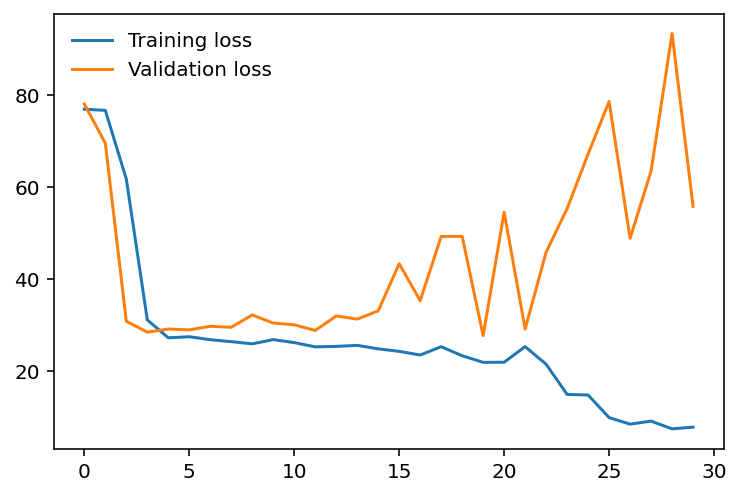

In [11]:
if mode == 'train':
    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'
    
    plt.plot(train_loss, label='Training loss')
    plt.plot(val_loss, label='Validation loss')
    plt.legend(frameon=False) 